In [1]:
# Computations
import numpy as np
import pandas as pd

# scipy
import scipy.stats as stats
from scipy.stats import norm

# preprocessing
from sklearn.preprocessing import StandardScaler

# sklearn
# from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.feature_selection import RFE
from sklearn.utils.fixes import loguniform
from sklearn.ensemble import RandomForestClassifier

# Visualisation libraries

## Text
from colorama import Fore, Back, Style
from IPython.display import Image, display, Markdown, Latex

## seaborn
import seaborn as sns
sns.set_context('paper', rc={'font.size':12,'axes.titlesize':14,'axes.labelsize':12})
sns.set_style('white')

## matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
import matplotlib.gridspec as gridspec
import matplotlib.colors
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline

## missingno
import missingno as msno

import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-info">
<font size="+3"><b>
Telco Customer Churn
</b></font>
</div>


In this article, we analyze and predict customer churn for [Telco Customer Churn data](https://www.kaggle.com/blastchar/telco-customer-churn).

### Dataset

* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device * protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents

| Columns     | Description     |
|------------------    |---------------------------------------------------------------------------------------------------------------------------------    |
| customerID     | Customer ID     |
| gender     | Whether the customer is a male or a female     |
| SeniorCitizen     | Whether the customer is a senior citizen or not (1, 0)     |
| Partner     | Whether the customer has a partner or not (Yes, No)     |
| Dependents     | Whether the customer has dependents or not (Yes, No)     |
| tenure     | Number of months the customer has stayed with the company     |
| PhoneService     | Whether the customer has a phone service or not (Yes, No)     |
| MultipleLines     | Whether the customer has multiple lines or not (Yes, No, No phone service)     |
| InternetService     | Customer’s internet service provider (DSL, Fiber optic, No)     |
| OnlineSecurity     | Whether the customer has online security or not (Yes, No, No internet service)     |
| OnlineBackup     | Whether the customer has an online backup or not (Yes, No, No internet service)     |
| DeviceProtection     | Whether the customer has device protection or not (Yes, No, No internet service)     |
| TechSupport     | Whether the customer has tech support or not (Yes, No, No internet service)     |
| StreamingTV     | Whether the customer has streaming TV or not (Yes, No, No internet service)     |
| StreamingMovies     | Whether the customer has streaming movies or not (Yes, No, No internet service)     |
| Contract     | The contract term of the customer (Month-to-month, One year, Two years)     |
| PaperlessBilling     | Whether the customer has paperless billing or not (Yes, No)     |
| PaymentMethod     | The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))     |
| MonthlyCharges     | The amount charged to the customer monthly     |
| TotalCharges     | The total amount charged to the customer     |
| Churn     | Whether the customer churned or not (Yes or No)     |

#### Loading the Dataset

In [2]:
Data = pd.read_csv('telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn_clean.csv')

# Modeling

In [3]:
df = Data.drop(columns = ['customer ID'])
Target = 'Churn'
X = df.drop(columns = [Target])
y = df[Target].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

display(pd.DataFrame(data={'Set':['X_train','X_test','y_train','y_test'],
               'Array Shape':[X_train.shape, X_test.shape, y_train.shape, y_test.shape]}).set_index('Set').T)
Labels = ['Remanined', 'Churned']

Set,X_train,X_test,y_train,y_test
Array Shape,"(4930, 22)","(2113, 22)","(4930,)","(2113,)"


Furthermore, we would like to standardize features by removing the mean and scaling to unit variance. In this [article](https://hatefdastour.github.io/portfolio/statistical_modeling/Pima_Indians_Diabetes_Data_Classification.html), we demonstrated the benefits of scaling data using [**StandardScaler()**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [4]:
scaler = StandardScaler()
_ = scaler.fit(X)
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = X.columns)

A number of functions that we use throughout this article.

In [5]:
def Performance(clf, X_test = X_test):
    df = pd.DataFrame()
    y_pred = clf.predict(X_test)
    df = df.append({'Score': clf.score(X_test, y_test),
                    'F1 Score': metrics.f1_score(y_test.values, y_pred, average= 'weighted'),
                    'Precision Score': metrics.precision_score(y_test.values, y_pred, average= 'weighted'),
                    'Recall Score':  metrics.recall_score(y_test.values, y_pred, average= 'weighted')}, ignore_index=True)
    display(df.style.hide_index())

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: SpringGreen' if v else '' for v in is_max]


def Feature_Ranking(clf):
    df = pd.DataFrame()
    for n in range(2, X.shape[1]):
        selector = RFE(estimator= clf, n_features_to_select=n, verbose=0)
        selector.fit(X_train, y_train)
        df = df.append({'Number of Features to Select': n,
                        'Score':metrics.accuracy_score(y_test, selector.predict(X_test)),
                        'Features': X.columns[selector.support_].tolist(),
                        'Best Features':X.columns[selector.ranking_ == 1].tolist()}, ignore_index=True)

    df = df[['Number of Features to Select', 'Score', 'Features', 'Best Features']]
    display(df.style.apply(highlight_max, subset=['Score']))
    return df.loc[df.Score == df.Score.max(), 'Features'].values[0]

def ROC_Curve(clf, X_test = X_test):
    # false positive rates, true positive rates and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])

    fig, ax = plt.subplots(1, 1, figsize=(5.5, 5.5))
    _ = ax.plot(fpr, tpr, lw=2, label = 'AUC = %0.2f' % metrics.auc(fpr, tpr))
    _ = ax.plot([0, 1], [0, 1],'r--', lw=2)
    _ = ax.legend(loc = 'lower right', fontsize = 14)
    _ = ax.set_xlim([0,1])
    # _ = ax.set_ylim([0,1])
    _ = ax.set_xlabel('False Positive Rate (FPR)')
    _ = ax.set_ylabel('True Positive Rate (TPR)')

For this set of data, we would like to implement Random Forest Classifier. which creates a set of decision trees from a randomly selected subset of the training set. It benefits from voting of different decision trees for classifying the final outputs.

F1 Score,Precision Score,Recall Score,Score
0.773707,0.773621,0.787033,0.787033


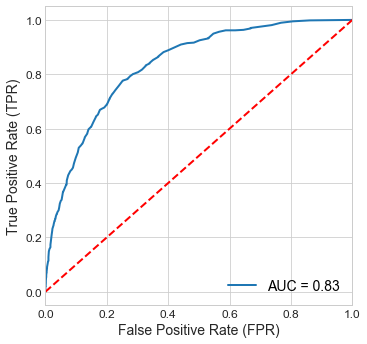

In [6]:
rfc = RandomForestClassifier()
_ = rfc.fit(X_train,y_train)
Performance(rfc)
ROC_Curve(rfc)

However, we only need to implement features that are useful for classifications. In this [article](https://hatefdastour.github.io/portfolio/statistical_modeling/Pima_Indians_Diabetes_Data_Classification_Feature_Importance.html), we demonstrated the importance of feature ranking.

In [7]:
Best_Features = Feature_Ranking(rfc)

,Number of Features to Select,Score,Features,Best Features
0,2.000000,0.772362,"['Monthly Charges', 'Total Charges']","['Monthly Charges', 'Total Charges']"
1,3.000000,0.773781,"['Tenure', 'Monthly Charges', 'Total Charges']","['Tenure', 'Monthly Charges', 'Total Charges']"
2,4.000000,0.768102,"['Tenure', 'Contract', 'Monthly Charges', 'Total Charges']","['Tenure', 'Contract', 'Monthly Charges', 'Total Charges']"
3,5.000000,0.767629,"['Tenure', 'Internet Service', 'Contract', 'Monthly Charges', 'Total Charges']","['Tenure', 'Internet Service', 'Contract', 'Monthly Charges', 'Total Charges']"
4,6.000000,0.772362,"['Tenure', 'Internet Service', 'Contract', 'Monthly Charges', 'Total Charges', 'Electronic check']","['Tenure', 'Internet Service', 'Contract', 'Monthly Charges', 'Total Charges', 'Electronic check']"
5,7.000000,0.777567,"['Tenure', 'Internet Service', 'Contract', 'Paperless Billing', 'Monthly Charges', 'Total Charges', 'Electronic check']","['Tenure', 'Internet Service', 'Contract', 'Paperless Billing', 'Monthly Charges', 'Total Charges', 'Electronic check']"
6,8.000000,0.783247,"['Gender', 'Tenure', 'Internet Service', 'Contract', 'Paperless Billing', 'Monthly Charges', 'Total Charges', 'Electronic check']","['Gender', 'Tenure', 'Internet Service', 'Contract', 'Paperless Billing', 'Monthly Charges', 'Total Charges', 'Electronic check']"
7,9.000000,0.782773,"['Gender', 'Partner', 'Tenure', 'Internet Service', 'Contract', 'Paperless Billing', 'Monthly Charges', 'Total Charges', 'Electronic check']","['Gender', 'Partner', 'Tenure', 'Internet Service', 'Contract', 'Paperless Billing', 'Monthly Charges', 'Total Charges', 'Electronic check']"
8,10.000000,0.788452,"['Gender', 'Partner', 'Tenure', 'Internet Service', 'Online Security', 'Contract', 'Paperless Billing', 'Monthly Charges', 'Total Charges', 'Electronic check']","['Gender', 'Partner', 'Tenure', 'Internet Service', 'Online Security', 'Contract', 'Paperless Billing', 'Monthly Charges', 'Total Charges', 'Electronic check']"
9,11.000000,0.781354,"['Gender', 'Partner', 'Tenure', 'Internet Service', 'Online Security', 'Online Backup', 'Contract', 'Paperless Billing', 'Monthly Charges', 'Total Charges', 'Electronic check']","['Gender', 'Partner', 'Tenure', 'Internet Service', 'Online Security', 'Online Backup', 'Contract', 'Paperless Billing', 'Monthly Charges', 'Total Charges', 'Electronic check']"


Thus, the best features:

In [8]:
print(Back.BLACK + Fore.CYAN + Style.NORMAL + 'Best Features:'+ Style.RESET_ALL + ' %s:' % ', '.join(Best_Features))

Best Features: Gender, Senior Citizen, Partner, Dependents, Tenure, Multiple Lines, Internet Service, Online Security, Online Backup, Device Protection, Tech Support, Streaming TV, Streaming Movies, Contract, Paperless Billing, Monthly Charges, Total Charges, Bank transfer (automatic), Electronic check, Mailed check:


F1 Score,Precision Score,Recall Score,Score
0.777324,0.777512,0.790345,0.790345


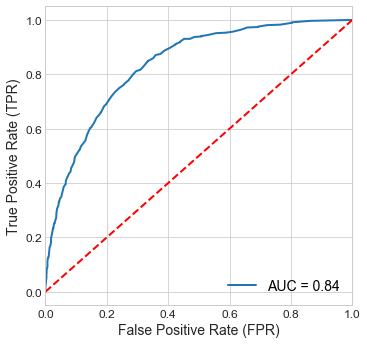

In [9]:
rfc = RandomForestClassifier()
_ = rfc.fit(X_train[Best_Features],y_train)
Performance(rfc, X_test[Best_Features])
ROC_Curve(rfc, X_test[Best_Features])

The main classification metrics:

In [10]:
pd.DataFrame(metrics.classification_report(y_test,rfc.predict(X_test[Best_Features]),
                                   output_dict = True, target_names = Labels))

,Remanined,Churned,accuracy,macro avg,weighted avg
precision,0.820093,0.663342,0.790345,0.741718,0.777512
recall,0.912281,0.463415,0.790345,0.687848,0.790345
f1-score,0.863734,0.545641,0.790345,0.704688,0.777324
support,1539.000000,574.000000,0.790345,2113.000000,2113.000000


A confusion matrix allows the visualization of the performance of a classification model.

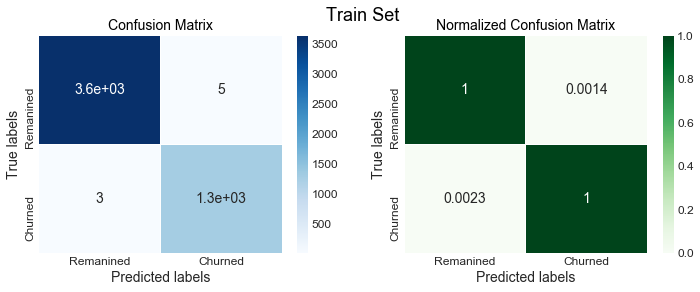

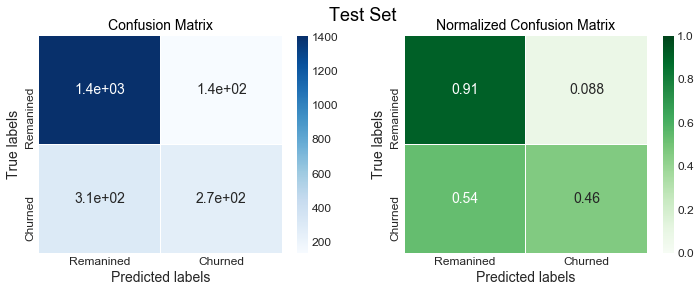

In [11]:
# Train set
y_pred = rfc.predict(X_train[Best_Features])
Confusion_Matrix = metrics.confusion_matrix(y_train, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Train Set', fontsize = 18)
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Blues", ax = ax[0],
               linewidths = 0.2, cbar_kws={"shrink": 1})
_ = ax[0].set_xlabel('Predicted labels')
_ = ax[0].set_ylabel('True labels'); 
_ = ax[0].set_title('Confusion Matrix');
_ = ax[0].xaxis.set_ticklabels(Labels)
_ = ax[0].yaxis.set_ticklabels(Labels)

Confusion_Matrix = Confusion_Matrix.astype('float') / Confusion_Matrix.sum(axis=1)[:, np.newaxis]
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Greens", ax = ax[1],
               linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": 1})
_ = ax[1].set_xlabel('Predicted labels')
_ = ax[1].set_ylabel('True labels'); 
_ = ax[1].set_title('Normalized Confusion Matrix');
_ = ax[1].xaxis.set_ticklabels(Labels)
_ = ax[1].yaxis.set_ticklabels(Labels)

# Test set
y_pred = rfc.predict(X_test[Best_Features])
Confusion_Matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Test Set', fontsize = 18)
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Blues", ax = ax[0],
                linewidths = 0.2, cbar_kws={"shrink": 1})
_ = ax[0].set_xlabel('Predicted labels')
_ = ax[0].set_ylabel('True labels'); 
_ = ax[0].set_title('Confusion Matrix');
_ = ax[0].xaxis.set_ticklabels(Labels)
_ = ax[0].yaxis.set_ticklabels(Labels)

Confusion_Matrix = Confusion_Matrix.astype('float') / Confusion_Matrix.sum(axis=1)[:, np.newaxis]
_ = sns.heatmap(Confusion_Matrix, annot=True, annot_kws={"size": 14}, cmap="Greens", ax = ax[1],
               linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": 1})
_ = ax[1].set_xlabel('Predicted labels')
_ = ax[1].set_ylabel('True labels'); 
_ = ax[1].set_title('Normalized Confusion Matrix');
_ = ax[1].xaxis.set_ticklabels(Labels)
_ = ax[1].yaxis.set_ticklabels(Labels)

# Predictions

Now for any given dataset, we can predict churn

In [12]:
Sample = df.sample(frac = 0.1)
X_sample = Sample.drop(columns = [Target])
X_sample = pd.DataFrame(scaler.transform(X_sample), columns = X.columns)
y_pred = rfc.predict(X_sample[Best_Features])
y_pred_proba = rfc.predict_proba(X_sample[Best_Features])
y_pred = pd.Series(y_pred).to_frame('Predicted Status').applymap(lambda x: Labels[0] if x ==0 else  Labels[1])
y_pred_proba = pd.DataFrame(y_pred_proba,columns = [x + ' Probability' for x in Labels])
Predictions = pd.concat([Data.loc[Sample.index, 'customer ID'].reset_index(drop = True), y_pred, y_pred_proba], axis = 1)
display(Predictions)

,customer ID,Predicted Status,Remanined Probability,Churned Probability
0,6457-GIRWB,Churned,0.00,1.00
1,5397-NSKQG,Remanined,0.96,0.04
2,0701-TJSEF,Remanined,0.88,0.12
3,9720-JJJOR,Remanined,0.90,0.10
4,7241-AJHFS,Remanined,0.82,0.18
...,...,...,...,...
699,8617-ENBDS,Remanined,0.78,0.22
700,9938-PRCVK,Remanined,1.00,0.00
701,8267-KFGYD,Remanined,0.92,0.08
702,9050-IKDZA,Churned,0.13,0.87


***